# Implémentation des modèles de simulation du papier

Ce notebook est fait pour reproduire des résultats similaire au papier [Estimating behavioral parameters in animal movement models using a state-augmented particle filter](https://dalspace.library.dal.ca/bitstream/handle/10222/33464/Dowd_et_al-2011-Ecology.pdf). 

Pour ce faire, nous avons défini des fonctions pour lancer les simulations du papier dans le module [`smc_movement_models.models`](../smc_movement_models/models.py), en utilisant la librairie `particles`.

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import smc_movement_models.models as smc_model
import smc_movement_models.plots as smc_plot

np.random.seed(42)

## Chargement des données

In [3]:
!pwd

/home/gwatk/Documents/ENSAE/HMM/smc_movement_models


In [4]:
# !cd ..
df = pd.read_csv("./data/clean_data.csv")

In [5]:
# day_str = "26/01/2008"
day_str_min = "18/01/2008"
day_str_max = "18/01/2008"
mask_day = (df["Date"] >= day_str_min) & (df["Date"] <= day_str_max)
day = df.loc[mask_day, ["Dtime", "Velocity", "Depth"]]
day["Dtime"] = pd.to_datetime(day["Dtime"])

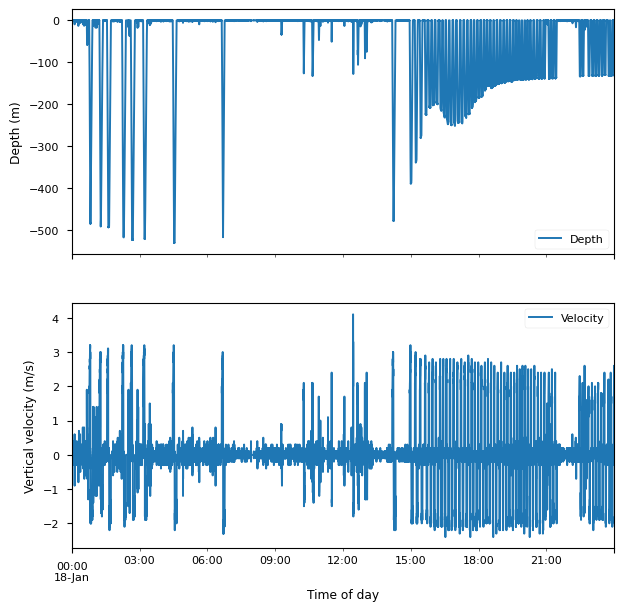

In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(7, 7))

day.plot(x="Dtime", y="Velocity", ax=ax2)
day.plot(x="Dtime", y="Depth", ax=ax1)
ax2.set(xlabel="Time of day", ylabel="Vertical velocity (m/s)")
ax1.set(xlabel="Time of day", ylabel="Depth (m)");

In [7]:
# Génération des fenêtres
windows, window_times = smc_model.get_windows(day)

In [8]:
print(f"There are {len(windows)} windows in the day.")

There are 109 windows in the day.


## Estimation des variances

Dans un premier temps, nous allons estimer les variances des erreurs de mesure et d'observation. Pour ce faire, nous utilisons la méthodologie décrite dans le papier en Annexe A.

In [9]:
sigma_ods, sigma_eds, sigma_zds, mses, acvfs = smc_model.estimate_variance_on_all_windows(windows)

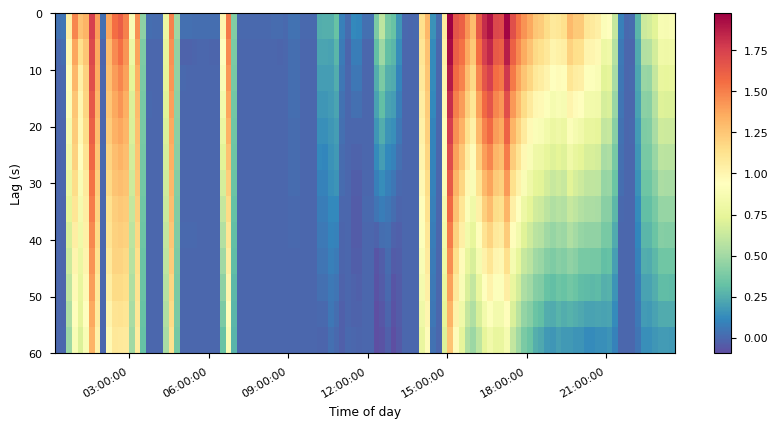

In [10]:
acvf_fig = smc_plot.plot_acvf(acvfs, window_times)

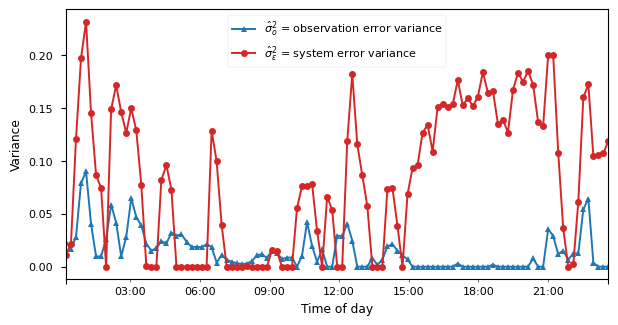

In [20]:
var_fig = smc_plot.plot_variance_estimates(sigma_eds, sigma_ods, window_times)

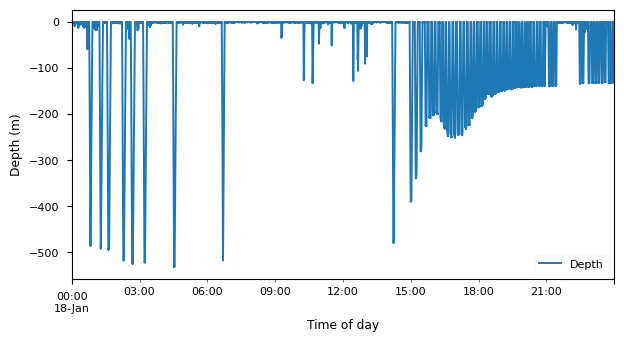

In [12]:
depth_fig = smc_plot.plot_depth(day)

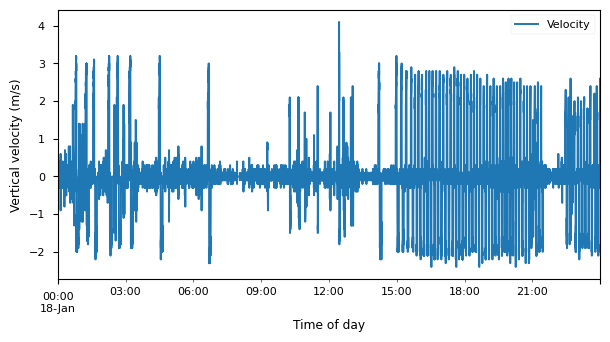

In [13]:
velocity_fig = smc_plot.plot_velocity(day)


## Estimation des paramètres latents

Dans cette section, nous allons estimer les paramètres latents du modèle. Pour ce faire, nous utilisons la méthodologie décrite dans le papier.

In [14]:
# Choix entre 0.5 et les estimations offline pour les variance des bruits
# sigma_os = np.sqrt(sigma_ods)  # L'estimation marche mal avec les estimations offline
# sigma_es = np.sqrt(sigma_eds)
sigma_os = np.ones_like(sigma_ods) * 0.5  # On utilise pluôt 0.5
sigma_es = np.ones_like(sigma_eds) * 0.5

In [ ]:
# Algorithme sur toutes les fenêtres (une fois)
time_results = smc_model.estimate_a1_a2_on_all_windows(
    windows=windows,  # List of windows data
    window_times=window_times,  # Time associated to each window
    sigma_os=sigma_os,  # Observation noise variance (one by window)
    sigma_es=sigma_es,  # System noise variance (one by window)
    N=500,  # Number of particles
    M=10,  # Number of iterations
    initial_a1=0,  # Initial value of the latent parameters
    initial_a2=0,
    initial_sigma_v=0.1,  # Initial variance of the latent parameters
    alpha=0.5,  # Discount factor
    c1=0.9,  # Mixture model definition
    c2=0.1,
    delta=10,
)

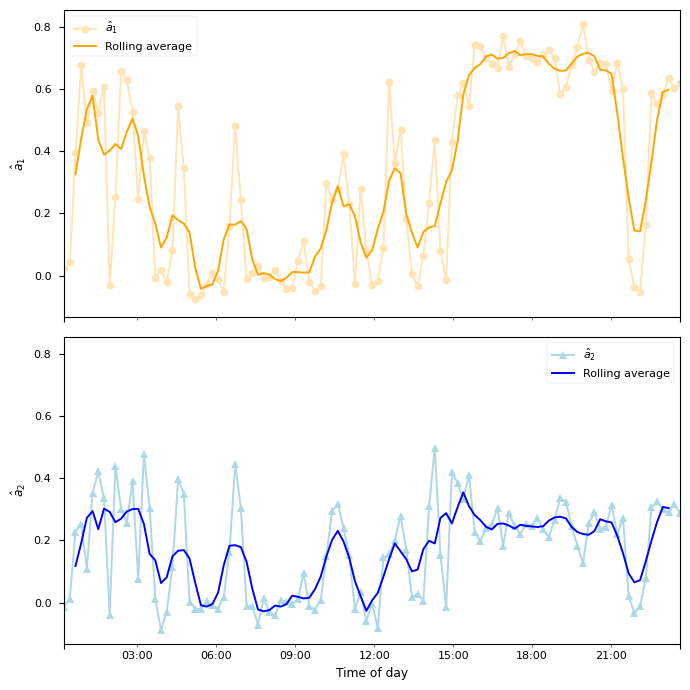

In [16]:
a1_a2_fig = smc_plot.plot_a1_a2(time_results, figsize=(7, 7))

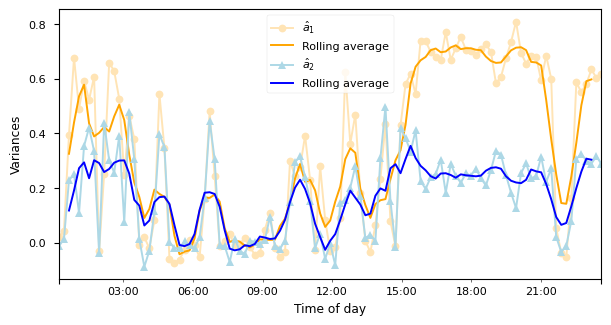

In [17]:
a1_a2_fig_single_plot = smc_plot.plot_a1_a2_single_plot(time_results, figsize=(7, 3.5))

In [ ]:
# On répète l'algorithme 10 fois pour avoir une idée de la variance des paramètres
results_var = []

for i in tqdm(range(10)):
    time_results = smc_model.estimate_a1_a2_on_all_windows(
        windows=windows,
        window_times=window_times,
        sigma_os=np.sqrt(sigma_ods),  # Ici, on essaie avec les estimations offline
        sigma_es=np.sqrt(sigma_eds),
        N=500,
        M=10,
        initial_a1=0,
        initial_a2=0,
        initial_sigma_v=0.1,
        alpha=0.5,
        c1=0.9,
        c2=0.1,
        delta=10,
    )
    results_var.append(time_results)

final_res = pd.DataFrame()
for i, res in enumerate(results_var):
    res["run"] = i
    final_res = pd.concat([final_res, res])

In [ ]:
a1_a2_var_fig10 = smc_plot.plot_a1_a2_var(final_res)

In [ ]:
# Meme chose mais dans une fonction et 20 fois (prend 30min)
final_res = smc_model.rerun_algo(
    windows=windows,
    window_times=window_times,
    sigma_os=sigma_os,  # On prend 0.5
    sigma_es=sigma_es,
    nb_runs=20,
    N=500,
    M=10,
    initial_a1=0,
    initial_a2=0,
    initial_sigma_v=0.1,
    alpha=0.5,
    c1=0.9,
    c2=0.1,
    delta=10,
)

C:\Users\gabri\AppData\Local\Temp\ipykernel_1532\1860597235.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=final_res["Dtime"].iloc[x_ids].dt.strftime('%H:%M'), rotation=45, ha='right')


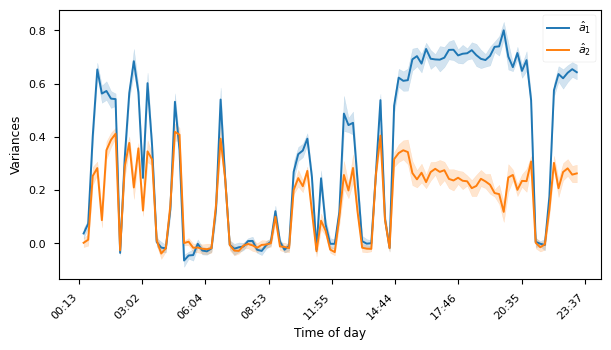

In [422]:
a1_a2_var_fig20 = smc_plot.plot_a1_a2_var(final_res)